In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv('anonymized-curriculum-access-07-2021.txt',  
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])

In [4]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


### Prepare

In [6]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [7]:
# resample daily counts for number of page views

pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

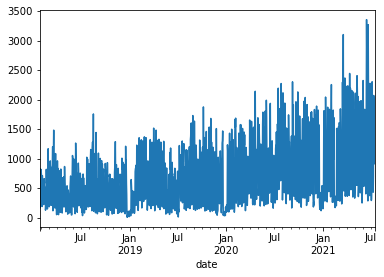

In [8]:
#plot pages
pages.plot()

Not splitting b/c not modeling. Using stats to identify cases

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value.

<AxesSubplot:xlabel='date'>

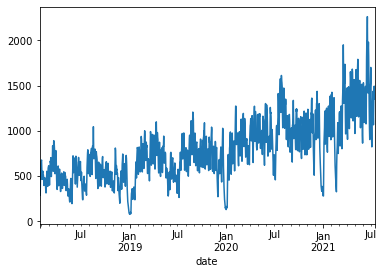

In [10]:
# 7 day EMA
ema_7d = pages.ewm(span = 7).mean()
ema_7d.plot()

<AxesSubplot:xlabel='date'>

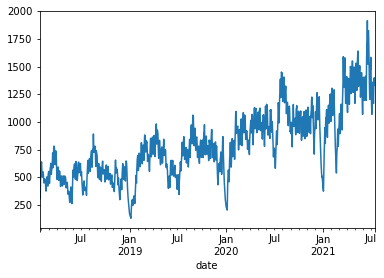

In [11]:
# 14 days EMA
ema_14d = pages.ewm(span = 14).mean()
ema_14d.plot()

In [12]:
# 30 days EMA
ema_30d = pages.ewm(span = 30).mean()

In [13]:
# 90 days EMA
ema_90d = pages.ewm(span = 90).mean()

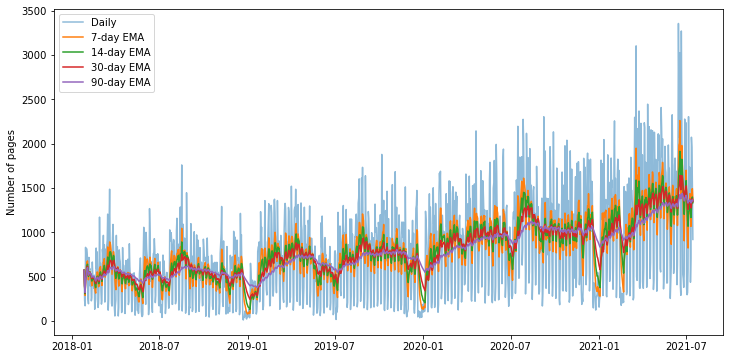

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

Note: the longer the period the less noisy.  The EMA reduces the impact of volatility on the Daily observation

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$



In [15]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span = 30).mean()
midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [16]:
# compute exponential moving stdev
std = pages.ewm(span = 30).std()
std.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [22]:
# compute upper and lower bands
ub = midband + std * 2
lb = midband - std * 2

ub.head()

date
2018-01-26            NaN
2018-01-27     878.961038
2018-01-28     742.895854
2018-01-29    1089.938060
2018-01-30    1070.328518
Freq: D, Name: endpoint, dtype: float64

In [23]:
# concat pages, midband, lb and ub to create a new df 'my_df'

my_df = pd.concat([pages, midband, ub, lb], axis =1)

my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038
2018-01-28,170,315.139578,742.895854,-112.616698
2018-01-29,830,457.002386,1089.938060,-175.933288
2018-01-30,652,501.369064,1070.328518,-67.590389


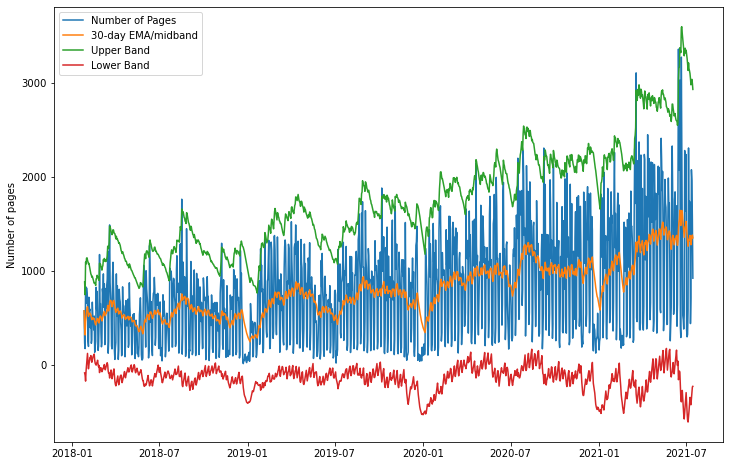

In [24]:
# Plot the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

Note: 

* The lower Bollinger Band is not relevant considering we can't have negative observations. 
    
* The Daily observations do not appear to cross the upper band @ 3 standard devations from the chart. A small number of observations appear to come close, worth investigating

    * after adjusting the bands to 2 standard deviations, we do start to see the upper band start acting as a resistance threshold with more observations testing the range but still a relatively small amount

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

In [27]:
# compute % b for each point
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/ (my_df['ub'] - my_df['lb'])
my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038,0.329116
2018-01-28,170,315.139578,742.895854,-112.616698,0.330348
2018-01-29,830,457.002386,1089.938060,-175.933288,0.794657
2018-01-30,652,501.369064,1070.328518,-67.590389,0.632374


In [33]:
# After finding no observations crossed the upper Bollinger Band at 3 standard deviations, let's check at 2 standard deviations
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845


In [32]:
my_df[my_df.pct_b > 1].count()

pages      13
midband    13
ub         13
lb         13
pct_b      13
dtype: int64

Note: After adjusting to 2 standard deviations we see the upper BB acting as an upper boundary.  We have 13 observations that cross the threshold but 0 that remain above the BB for 2 consecutive days.  

### Put it all together

1. acquire
2. prep with user
3. compute features
    - compute midband
    - compute standard deviation
    - compute upper & lower band
    - create df with metrics
    - compute %b
    - add user_id to dataframe
4. Plot
5. search for anomalies

In [58]:
def acquire(file_name, column_names):
    ''' read in txt file into df and assign column names'''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''prep df by converting date from object into datetime format and setting as index. Rename and resample endpoint column to daily counts given user_id'''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''computing [midband, std, upperband, lowerband], filtering df by defined user_id and concating all into one df'''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev * weight
    lb = midband - stdev * weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    #     plt_bands(my_df, user)
    return my_df[my_df.pct_b > 1]

1) acquire

In [36]:
df = acquire('anonymized-curriculum-access-07-2021.txt', ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip'])

In [37]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018810 entries, 0 to 1018809
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   date       1018810 non-null  object 
 1   endpoint   1018809 non-null  object 
 2   user_id    1018810 non-null  int64  
 3   cohort_id  965313 non-null   float64
 4   source_ip  1018810 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 38.9+ MB


2) prep with user

In [59]:
df.user_id.max()

1082

In [43]:
prep(df, 40)

date
2018-01-26     1
2018-01-27     0
2018-01-28     0
2018-01-29    14
2018-01-30     1
              ..
2020-03-13     0
2020-03-14     0
2020-03-15     0
2020-03-16     0
2020-03-17     3
Freq: D, Name: endpoint, Length: 782, dtype: int64

3. compute features
    
* compute midband
* compute standard deviation
* compute upper & lower band
* create df with metrics
* compute %b
* add user_id to dataframe

In [56]:
my_df = compute_pct_b(pages, 30, 2, 40)
   

In [57]:
my_df.head()

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN,40
2018-01-27,230,395.300000,878.961038,-88.361038,0.329116,40
2018-01-28,170,315.139578,742.895854,-112.616698,0.330348,40
2018-01-29,830,457.002386,1089.938060,-175.933288,0.794657,40
2018-01-30,652,501.369064,1070.328518,-67.590389,0.632374,40


4) Plot

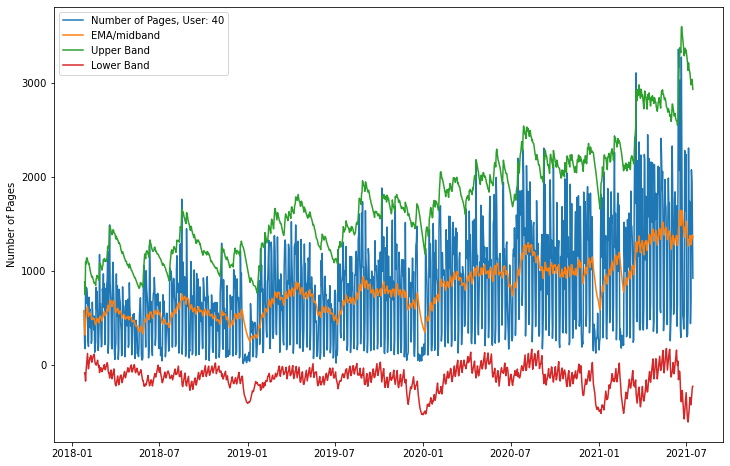

In [60]:
 plt_bands(my_df, 40)